In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import utility
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Consumption-Saving Model with Endogenous Labor Supply


In [5]:
from ConSavModel import ConSavModelClass

model = ConSavModelClass(name='endogenous_labor_supply')

par = model.par
sol = model.sol
sim = model.sim

model.solve(do_print=True,algo='egm')

iteration    0 solved in 3.6 secs   [max abs. diff. 1.71e+00]
iteration    1 solved in 0.0 secs   [max abs. diff. 4.78e-01]
iteration    2 solved in 0.0 secs   [max abs. diff. 3.07e-01]
iteration    3 solved in 0.0 secs   [max abs. diff. 2.20e-01]
iteration    4 solved in 0.0 secs   [max abs. diff. 1.68e-01]
iteration    5 solved in 0.0 secs   [max abs. diff. 1.33e-01]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.08e-01]
iteration    7 solved in 0.0 secs   [max abs. diff. 9.02e-02]
iteration    8 solved in 0.0 secs   [max abs. diff. 7.62e-02]
iteration    9 solved in 0.0 secs   [max abs. diff. 6.52e-02]
iteration  100 solved in 0.0 secs   [max abs. diff. 1.24e-04]
iteration  200 solved in 0.0 secs   [max abs. diff. 7.36e-07]
iteration  267 solved in 0.0 secs   [max abs. diff. 8.90e-09]
model solved in 4.0 secs


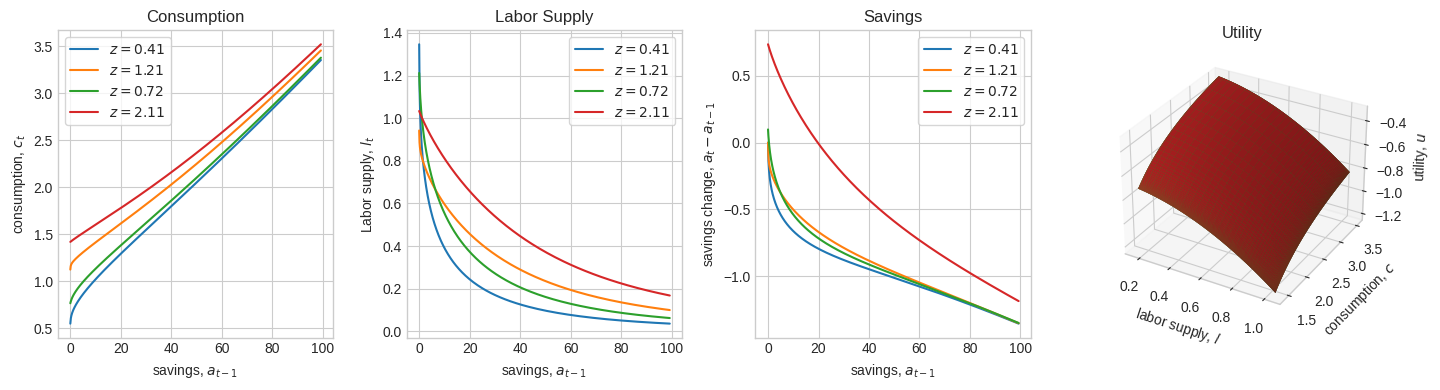

In [6]:
fig = plt.figure(figsize=(14,4),dpi=100)

I = par.a_grid < 100

# Consumption
ax = fig.add_subplot(1,4,1)
ax.set_title(f'Consumption')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol.c[i_z, :][I], label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.legend(frameon=True)

# Labor Supply
ax = fig.add_subplot(1,4,2)
ax.set_title(f'Labor Supply')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol.l[i_z, :][I],label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('Labor supply, $l_t$')
ax.legend(frameon=True)

# Savings
ax = fig.add_subplot(1,4,3)
ax.set_title(f'Savings')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol.a[i_z, :][I]-par.a_grid[I],label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_t - a_{t-1}$')
ax.legend(frameon=True)

ax = fig.add_subplot(1,4,4,projection='3d')
ax.set_title(f'Utility')

# Prepare 3D arrays for consumption, labor supply, and utility
C, L = np.meshgrid(sol.c[i_z,:][I], sol.l[i_z,:][I])
U = utility.func_2(C, L, par)

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        # Draw 3D surface plot
        ax.plot_surface(L, C, U, label=f'$z={z:.2f}$')

ax.set_xlabel('labor supply, $l$')
ax.set_ylabel('consumption, $c$')
ax.set_zlabel('utility, $u$')

fig.tight_layout()
plt.show()

In [7]:
model_exo = ConSavModelClass(name='exogenous_labor_supply')

sol_exo = model_exo.sol
sim_exo = model_exo.sim

model_exo.solve(do_print=True,algo='egm_exo')

iteration    0 solved in 3.3 secs   [max abs. diff. 2.52e+02]
iteration    1 solved in 0.0 secs   [max abs. diff. 8.39e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 4.19e+01]
iteration    3 solved in 0.0 secs   [max abs. diff. 2.51e+01]
iteration    4 solved in 0.0 secs   [max abs. diff. 1.67e+01]
iteration    5 solved in 0.0 secs   [max abs. diff. 1.20e+01]
iteration    6 solved in 0.0 secs   [max abs. diff. 8.96e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 6.96e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 5.56e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 4.54e+00]
iteration  100 solved in 0.0 secs   [max abs. diff. 2.27e-02]
iteration  200 solved in 0.0 secs   [max abs. diff. 8.32e-04]
iteration  300 solved in 0.0 secs   [max abs. diff. 1.80e-05]
iteration  400 solved in 0.0 secs   [max abs. diff. 9.74e-09]
model solved in 3.4 secs


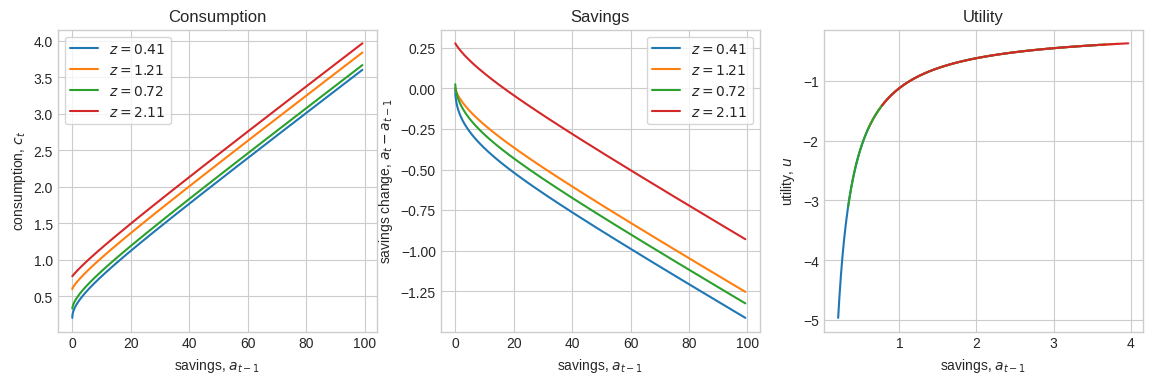

In [32]:
fig = plt.figure(figsize=(14,4),dpi=100)

I = par.a_grid < 100

# a. consumption
ax = fig.add_subplot(1,3,1)
ax.set_title(f'Consumption')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol_exo.c[i_z, :][I], label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.legend(frameon=True)

# Savings
ax = fig.add_subplot(1,3,2)
ax.set_title(f'Savings')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I], sol_exo.a[i_z, :][I]-par.a_grid[I],label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_t - a_{t-1}$')
ax.legend(frameon=True)

# Utility
ax = fig.add_subplot(1,3,3)
ax.set_title(f'Utility')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz:
        ax.plot(sol_exo.c[i_z,:][I], sol_exo.u[i_z,:][I],label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('utility, $u$')

plt.show()

In [9]:
tau_vec = [0.0,0.05,0.1,0.15,0.2,0.25]
U_endo = np.zeros(len(tau_vec))
L_endo = np.zeros(len(tau_vec))
C_endo = np.zeros(len(tau_vec))
A_endo = np.zeros(len(tau_vec))

for i, tau in enumerate(tau_vec):
    model_tau = ConSavModelClass(name='range',par={'tau':tau})
    model_tau.solve(do_print=False,algo='egm')
    L_endo[i] = np.mean(model_tau.sol.l)
    U_endo[i] = np.mean(model_tau.sol.u)
    C_endo[i] = np.mean(model_tau.sol.c)
    A_endo[i] = np.mean(model_tau.sol.a)

U_exo = np.zeros(len(tau_vec))
L_exo = np.zeros(len(tau_vec))
C_exo = np.zeros(len(tau_vec))
A_exo = np.zeros(len(tau_vec))

for i, tau in enumerate(tau_vec):
    model_tau_exo = ConSavModelClass(name='range',par={'tau':tau})
    model_tau_exo.solve(do_print=False,algo='egm_exo')
    L_exo[i] = np.mean(model_tau_exo.sol.ell)
    U_exo[i] = np.mean(model_tau_exo.sol.u)
    C_exo[i] = np.mean(model_tau_exo.sol.c)
    A_exo[i] = np.mean(model_tau_exo.sol.a)

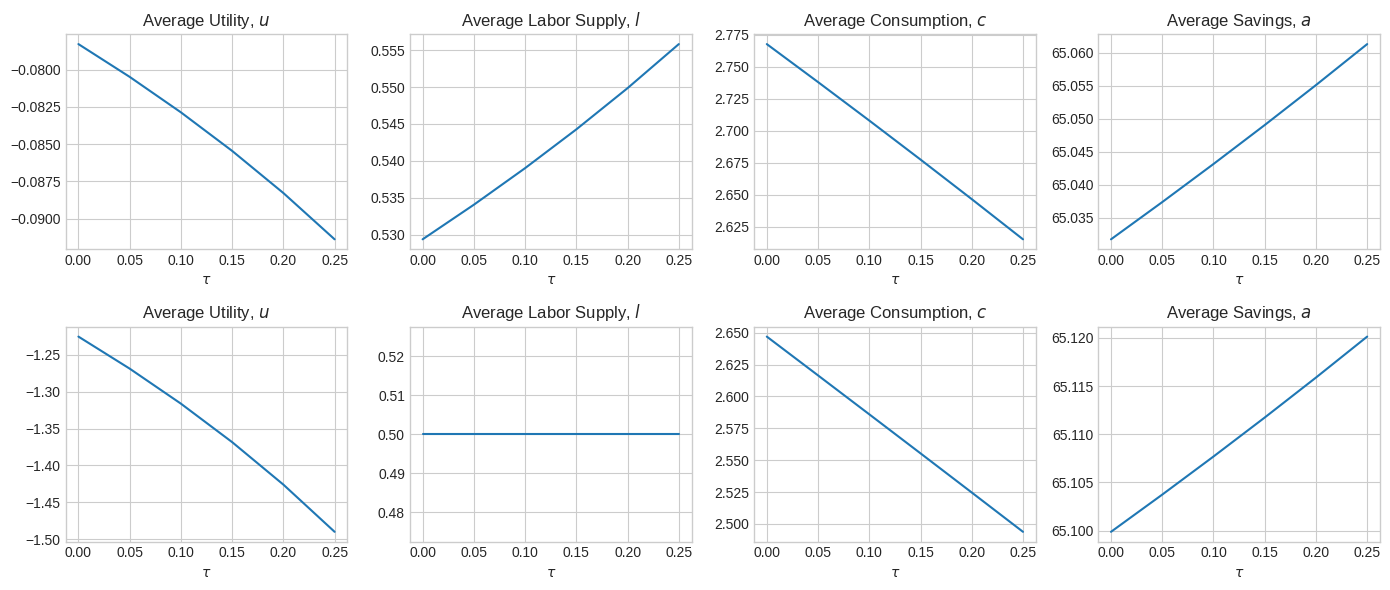

In [10]:
fig = plt.figure(figsize=(14,6), dpi=100)  # Set the figsize to accommodate a 2x4 layout

# First row
ax = fig.add_subplot(2, 4, 1)
ax.set_title('Average Utility, $u$')
ax.plot(tau_vec, U_endo, '-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(2, 4, 2)
ax.set_title('Average Labor Supply, $l$')
ax.plot(tau_vec, L_endo, '-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(2, 4, 3)
ax.set_title('Average Consumption, $c$')
ax.plot(tau_vec, C_endo, '-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(2, 4, 4)
ax.set_title('Average Savings, $a$')
ax.plot(tau_vec, A_endo, '-')
ax.set_xlabel('$\\tau$')

# Second row
ax = fig.add_subplot(2, 4, 5)
ax.set_title('Average Utility, $u$')
ax.plot(tau_vec, U_exo, '-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(2, 4, 6)
ax.set_title('Average Labor Supply, $l$')
ax.plot(tau_vec, L_exo, '-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(2, 4, 7)
ax.set_title('Average Consumption, $c$')
ax.plot(tau_vec, C_exo, '-')
ax.set_xlabel('$\\tau$')

ax = fig.add_subplot(2, 4, 8)
ax.set_title('Average Savings, $a$')
ax.plot(tau_vec, A_exo, '-')
ax.set_xlabel('$\\tau$')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [37]:
from tools import calc_mpc

# Calculate and print the MPC for both models
mpc_egm = calc_mpc(model, 'egm')
mpc_egm_exo = calc_mpc(model_exo, 'egm_exo')


np.set_printoptions(precision=None, suppress=True, threshold=np.inf)

print(f'{np.mean(mpc_egm):.3f}')

print(f'{np.mean(mpc_egm_exo):.3f}')

# print(mpc_egm_exo)

0.579
0.596


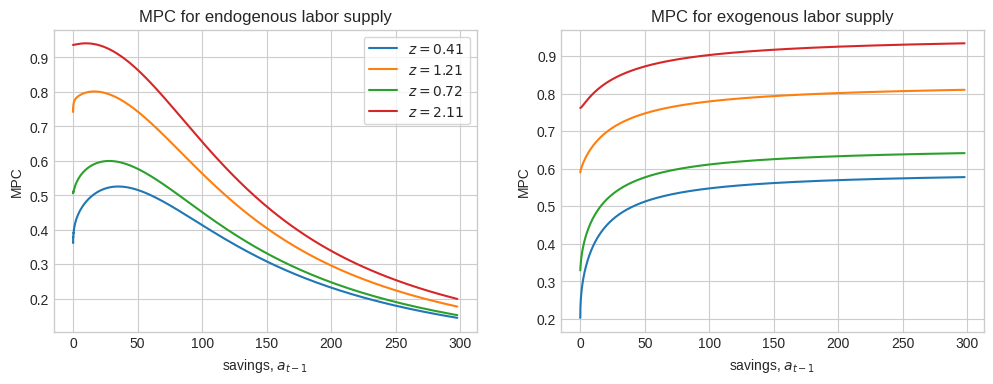

In [29]:
fig = plt.figure(figsize=(12,4),dpi=100)

I = par.a_grid < 300

# a. consumption
ax = fig.add_subplot(1,2,1)
ax.set_title(f'MPC for endogenous labor supply')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz:
        ax.plot(par.a_grid[I], mpc_egm[i_z,][I], label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('MPC')
ax.legend(frameon=True)

# a. consumption
ax = fig.add_subplot(1,2,2)
ax.set_title(f'MPC for exogenous labor supply')

for i_z, z in enumerate(par.z_grid):
    if i_z % 3 == 0 or i_z == par.Nz:
        ax.plot(par.a_grid[I], mpc_egm_exo[i_z, :][I], label=f'$z={z:.2f}$')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('MPC')
# ax.legend(frameon=True)

plt.show()

In [13]:
# model.prepare_simulate()
model.simulate(algo='mc', do_print=True)

model simulated in 3.7 secs secs


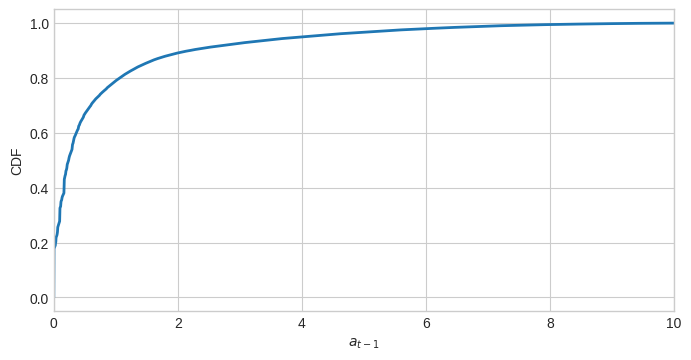

In [14]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(1,1,1)

CDF_mc = np.zeros(par.Na)
for i_a in range(par.Na):
    CDF_mc[i_a] = np.sum(sim.a[-1,:] < par.a_grid[i_a])/par.simN


ax.plot(par.a_grid,CDF_mc,lw=2,label='monte carlo')

ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('CDF')
ax.set_xlim([par.b,10.0])
plt.show()
# ax.legend(frameon=True);

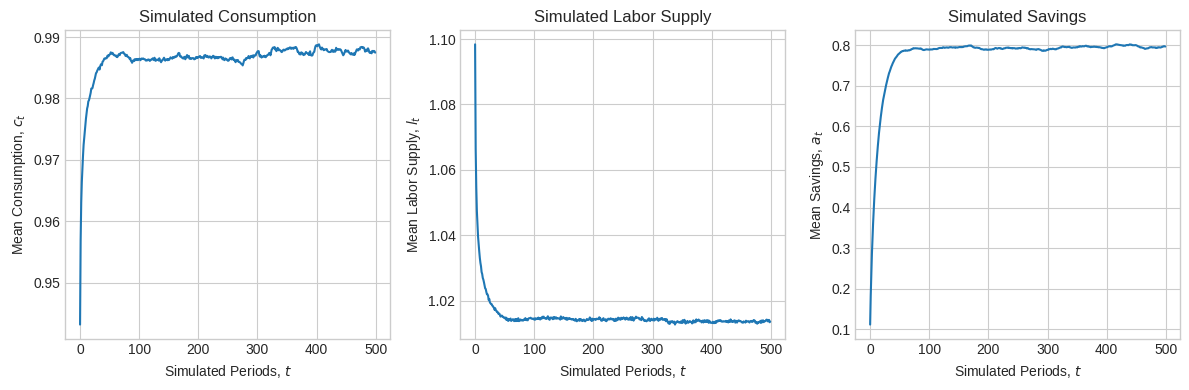

In [15]:
# Calculate the mean of a and l for each period
a_mean = sim.a.mean(axis=1)
l_mean = sim.l.mean(axis=1)
c_mean = sim.c.mean(axis=1)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100)

# a. consumption
ax[0].plot(np.arange(par.simT), c_mean)
ax[0].set_title('Simulated Consumption')
ax[0].set_xlabel('Simulated Periods, $t$')
ax[0].set_ylabel('Mean Consumption, $c_t$')


# b. labor supply
ax[1].plot(np.arange(par.simT), l_mean)
ax[1].set_title('Simulated Labor Supply')
ax[1].set_xlabel('Simulated Periods, $t$')
ax[1].set_ylabel('Mean Labor Supply, $l_t$')

# b. savings
ax[2].plot(np.arange(par.simT), a_mean)
ax[2].set_title('Simulated Savings')
ax[2].set_xlabel('Simulated Periods, $t$')
ax[2].set_ylabel('Mean Savings, $a_t$')

fig.tight_layout()
plt.show()